# Analysis on Gait Features between PD vs Controls

This notebook is used for visualizing gait features between Parkinson's Disease Cases vs Controls based on <b> mPower Walk Table Freeze </b> accumulated from 4 years of walking activity collection based on appVersion 1

- Each features will be assessed by collapsing features based on a healthcode
- It will rank each features by its p-values (independent t-test adjusted by bonferroni correction)
- Compare between subsampled user (matched age-gender demographics) to see how each features are different pre and post matching
- Note: Feature values are scaled from 0-1 for ease of interpretability

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import synapseclient as sc
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from analysis_utils import *


warnings.simplefilter("ignore")
sns.set_style("darkgrid", {"axes.facecolor": ".9", 'grid.color': '.8'})

%matplotlib inline
%load_ext autoreload
%autoreload 2

syn = sc.login()

Welcome, Aryton Tediarjo!



### Helper

In [17]:
def get_p_val(data):
    p_val = {}
    for feat in feat_used:
        control = data[data["PD"] == 0].dropna()[feat]
        PD = data[data["PD"] == 1].dropna()[feat]
        scaled_control = (control - control.min())/(control.max()-control.min())
        scaled_PD = (PD - PD.min())/(PD.max()-PD.min())

        t, pvalue_non_parametric = stats.mannwhitneyu(
            scaled_PD,
            scaled_control, alternative=None)

        t, pvalue_parametric = stats.ttest_ind(
            scaled_PD,
            scaled_control, 
            equal_var = False)
        p_val[feat] = [pvalue_non_parametric, pvalue_parametric]

    p_val = pd.DataFrame(p_val).T.rename({0:"Mann-Whitney", 1:"T-test"}, axis = 1)
    p_val["corrected_p_val"] = multipletests(p_val["T-test"], method = "bonferroni")[1]
    p_val = p_val.sort_values("corrected_p_val")
    return p_val

## Feature Retrieval and Cleaning

### Global Variables

In [2]:
WALK_FEATURES = "syn22294860"
DEMOGRAPHICS = "syn7222419"
MATCHED_HC = "syn22254800"

### Get Required Data

In [3]:
features = pd.read_csv(
    syn.get(WALK_FEATURES)["path"], sep = "\t")
matched_hc = pd.read_csv(
    syn.get(MATCHED_HC)["path"], sep = "\t")

### Aggregate Features

In [4]:
agg_freeze_feat = get_agg_fog_features(features, 2.5)
agg_gait_feat = get_agg_features(features)
agg_data = agg_gait_feat.join(agg_freeze_feat)
feat_used = [feat for feat in agg_data.columns if ("createdOn" not in feat) 
             and ("window" not in feat) 
             and ("error" not in feat) 
             and ('nrecords' not in feat)]
agg_data = agg_data[feat_used]

### Retrieve and Aggregate Demographics

In [5]:
demo = syn.tableQuery("SELECT * FROM %s" % DEMOGRAPHICS).asDataFrame()
demo["PD"] = np.where(demo["professional-diagnosis"] == True, 1, 0)
demo = demo[["age", "gender", "healthCode", "PD"]]\
    .groupby("healthCode")\
    .agg({
    "age":"mean",
    "gender":pd.Series.mode,
    "PD": pd.Series.mode})
demo = demo[(demo["gender"].str.lower() == "male")| 
     (demo["gender"].str.lower() == "female") | 
     (demo["gender"].str.lower() == "prefer not to answer")]

### Join Demographics and Aggregated Features

In [26]:
data = agg_data.join(demo, how = "inner")\
                .dropna(subset = ["age","gender", "PD"]).dropna()

In [25]:
data.to_csv("cleaned_walk_features.tsv", sep = "\t")

## Comparison of Features Before/After Healthcode Matching

### a). Before Matching

#### i). Some Demographics Diagnostics

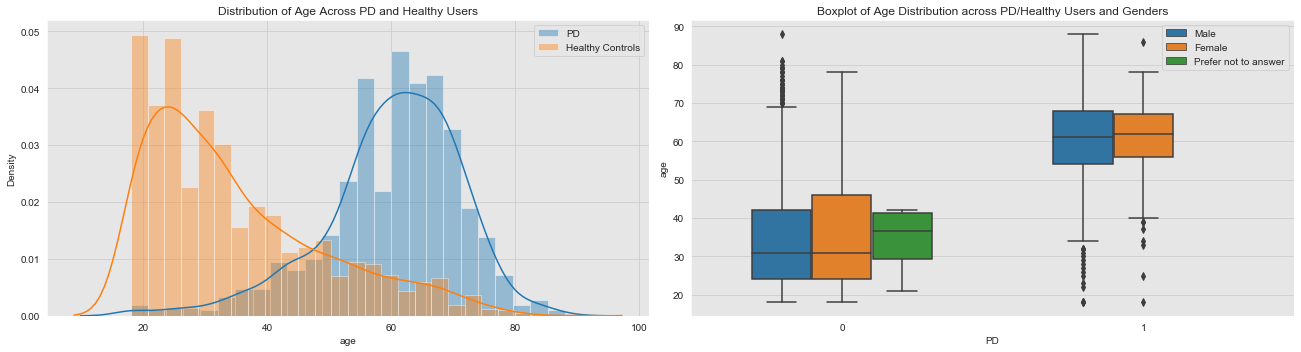

In [27]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

sns.distplot(
    data[data["PD"] == 1]["age"], 
    ax = axes[0], 
    label = "PD")
sns.distplot(
    data[data["PD"] == 0]["age"], 
    ax = axes[0], 
    label = "Healthy Controls")
axes[0].legend(bbox_to_anchor=(1, 1))
axes[0].set_title("Distribution of Age Across PD and Healthy Users")
axes[0].set_ylabel("Density")


sns.boxplot(y = data["age"], 
            x = data["PD"], 
            hue = data["gender"],
            ax = axes[1], 
            width = 0.6)
axes[1].legend(bbox_to_anchor=(1, 1))
axes[1].set_title("Boxplot of Age Distribution across PD/Healthy Users and Genders")

fig.tight_layout()
fig.show()

#### ii). Ranking by p-values (T-Test, Mann Whitney)

In [28]:
p_val_unmatched = get_p_val(data)

#### iii). Distribution of each features (Ranked by p-values)

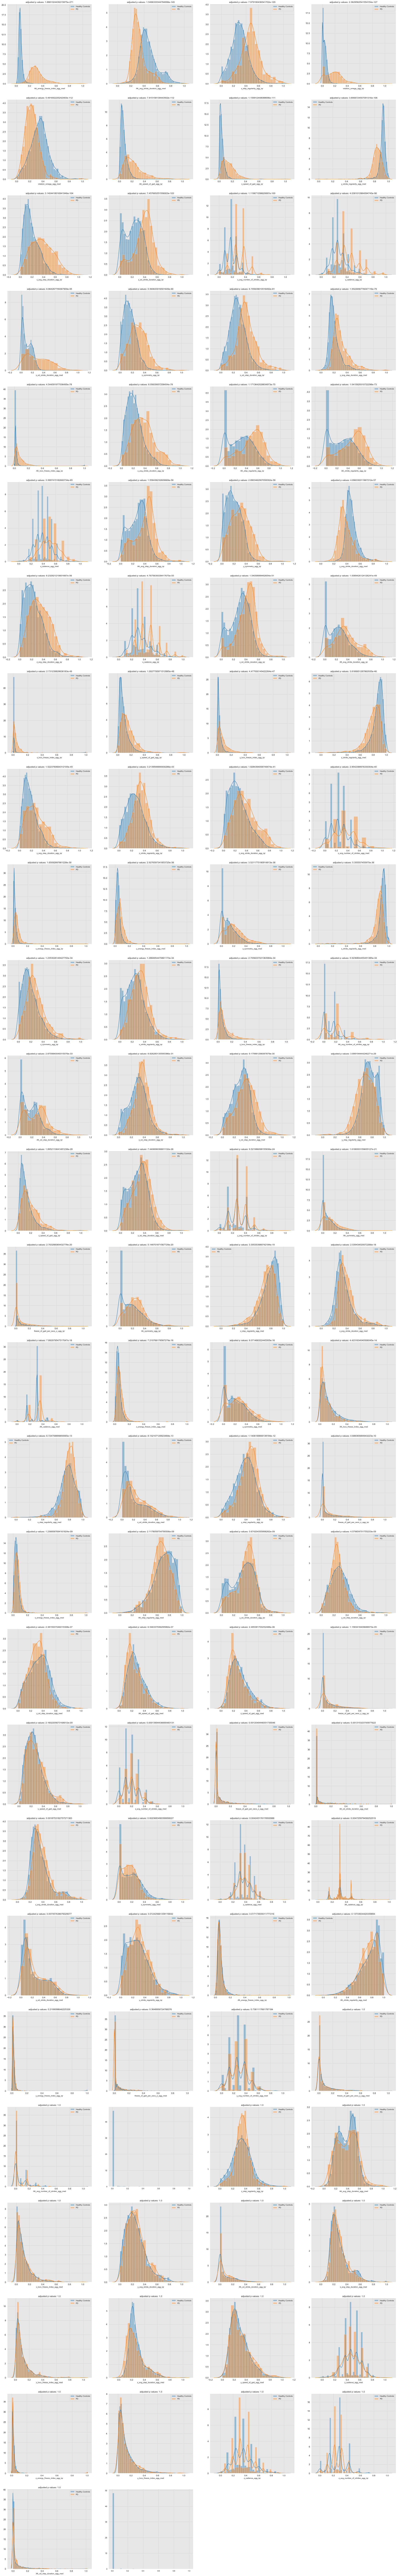

In [29]:
fig, axs = plt.subplots(ncols=4, nrows=0, figsize=(15, 150))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=5)
for i, feature in enumerate(list(p_val_unmatched.index), 1):
    try:
        plt.subplot(len(feat_used), 4, i)
        control = data[data["PD"] == 0].dropna()[feature]
        PD = data[data["PD"] == 1].dropna()[feature]
        scaled_control = (control - control.min())/(control.max()-control.min())
        scaled_PD = (PD - PD.min())/(PD.max()-PD.min())
        sns.distplot(
            scaled_control, 
            label = "Healthy Controls")
        sns.distplot(
            scaled_PD,  
            label = "PD")
        plt.legend()
        plt.title("adjusted p values: %s" %p_val_unmatched.loc[feature]["corrected_p_val"])
        for _ in range(2):
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)
    except:
        pass
plt.show()

## After Matching

In [30]:
matched_data = data.join(matched_hc[["healthCode"]].set_index("healthCode"), how = "inner")

### b). Demographics Diagnostics after Matching

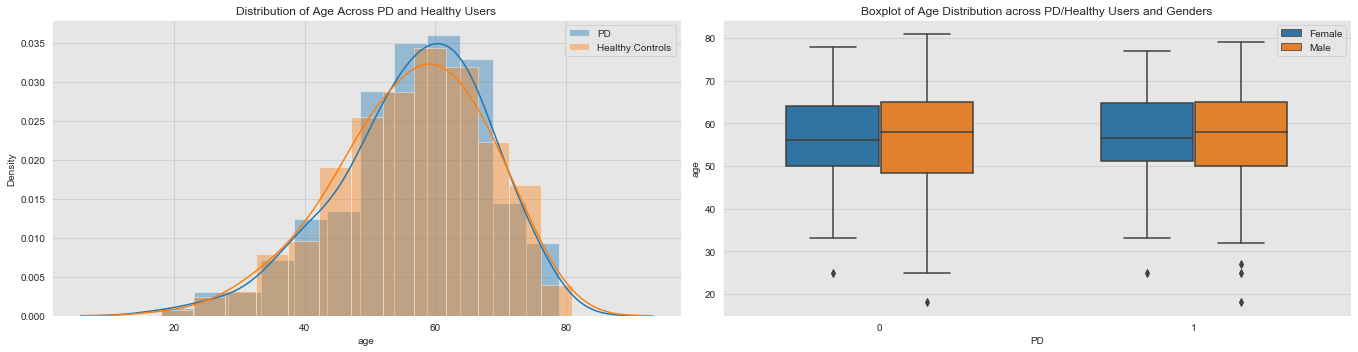

In [31]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

sns.distplot(
    matched_data[matched_data["PD"] == 1]["age"], 
    ax = axes[0], 
    label = "PD")
sns.distplot(
    matched_data[matched_data["PD"] == 0]["age"], 
    ax = axes[0], 
    label = "Healthy Controls")
axes[0].legend(bbox_to_anchor=(1, 1))
axes[0].set_title("Distribution of Age Across PD and Healthy Users")
axes[0].set_ylabel("Density")


sns.boxplot(y = matched_data["age"], 
            x = matched_data["PD"], 
            hue = matched_data["gender"],
            ax = axes[1], 
            width = 0.6)
axes[1].legend(bbox_to_anchor=(1, 1))
axes[1].set_title("Boxplot of Age Distribution across PD/Healthy Users and Genders")

fig.tight_layout()
fig.show()

#### i). Get p-values of matched dataset

In [32]:
p_val_matched = get_p_val(matched_data)

#### ii).  Matched figures between PD Case vs Controls

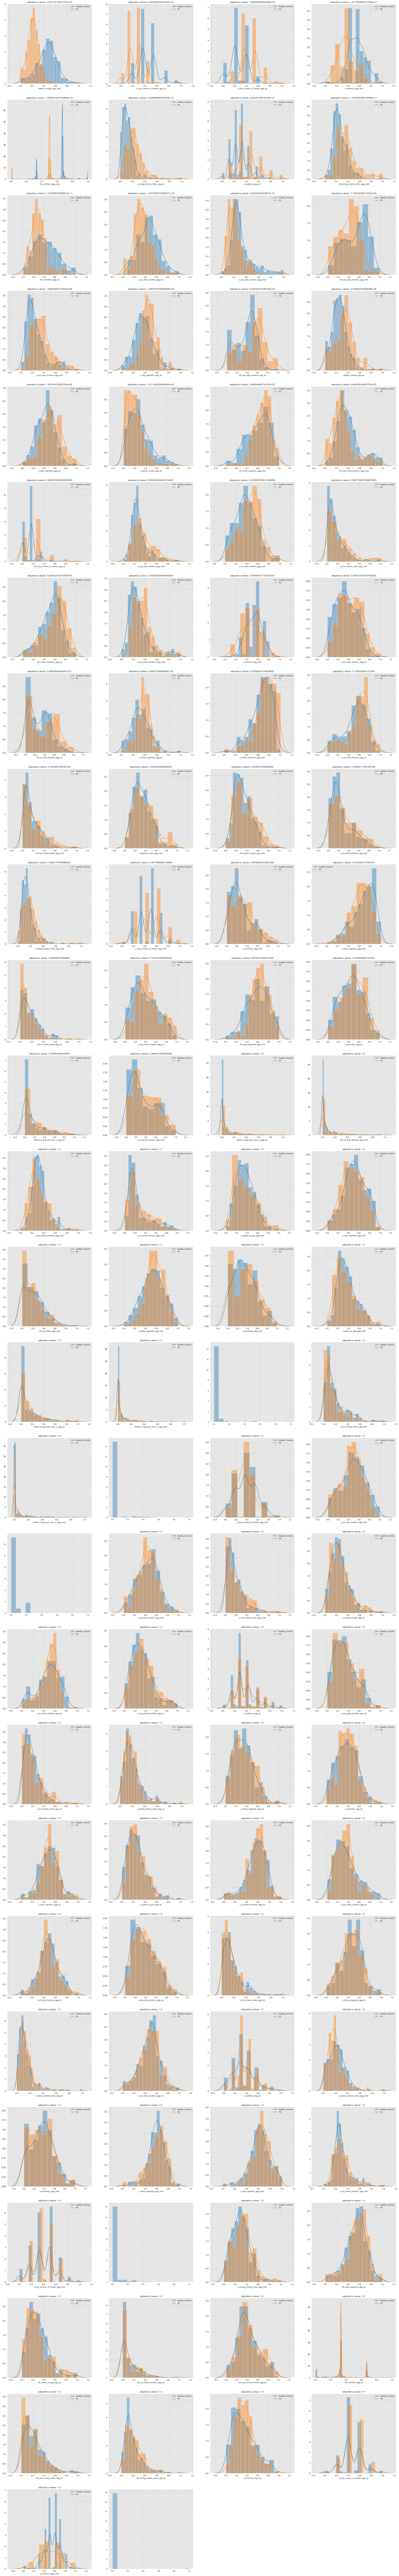

In [33]:
fig, axs = plt.subplots(ncols=4, nrows=0, figsize=(15, 150))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=5)
for i, feature in enumerate(list(p_val_matched.index), 1):
    try:
        plt.subplot(len(feat_used), 4, i)
        control = matched_data[matched_data["PD"] == 0].dropna()[feature]
        PD = matched_data[matched_data["PD"] == 1].dropna()[feature]
        scaled_control = (control - control.min())/(control.max()-control.min())
        scaled_PD = (PD - PD.min())/(PD.max()-PD.min())
        sns.distplot(
            scaled_control, 
            label = "Healthy Controls")
        sns.distplot(
            scaled_PD,  
            label = "PD")
        plt.legend()
        plt.title("adjusted p values: %s" %p_val_matched.loc[feature]["corrected_p_val"])
        for _ in range(2):
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)
    except:
        pass
plt.show()